In [1]:
# -*- coding: utf-8 -*-
"""
    IMU & CAM server
    22.01.2020
    Version 1.0
    by Dipl.-Ing (FH) Sebastian Keidler, M. Sc. 
    ADrive LivingLab Kempten
"""

__author__ = "Dipl.-Ing(FH) Sebastian Keidler"
__version__ = "1.0"
__email___ = "sebastian.keidler@hs-kempten.de"

In [2]:
#%% Bibliotheks
import struct
import socket                                         
import getNND2Lcoordinates as dt
import classes.cCROLayer0 as l0
import matplotlib.pyplot as plt
from time import sleep
import numpy as np
import classes.cSegmentAnalyzer as sa
import classes.cDistance2Line as d2l

In [3]:
oSegment = sa.cSegmentAnalyzer()
oDistance2Line = d2l.cDistance2Line()

In [4]:
sRoadName = 'A7'
sRoadDirection = 'N'
sLayer = '0'
sResolution = '1'
sRefLine = 'P0'

#import class to load CRO DATA 
oCROLayer0 = l0.cCROLayer0()
dfCRORoadL0 = oCROLayer0.importRoadData(oCROLayer0.sParentDir,sRoadName,
                               sRoadDirection,str(0),sResolution)

dfCRORoadL1 = oCROLayer0.importRoadData(oCROLayer0.sParentDir,sRoadName,
                               sRoadDirection,str(1),sResolution)

#create numpy array for Nearest Neigbour search
afRoadNN = oSegment.createNNRoadArray(dfCRORoadL0,
                                      'Line'+str(sRefLine)+'_lat',
                                      'Line'+str(sRefLine)+'_lon')

<IPython.core.display.Javascript object>


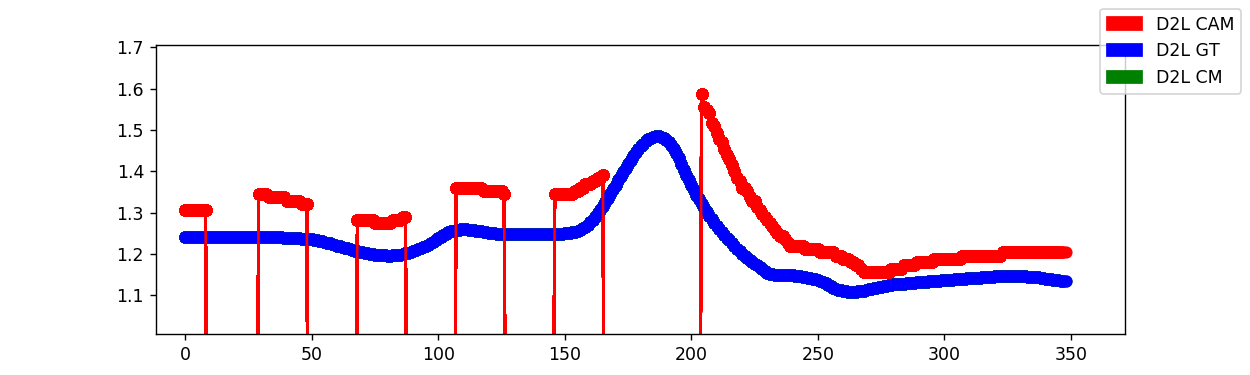

C:\Users\ll_stsekeid\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
import matplotlib.patches as mpatches
%matplotlib notebook
i = 0
x, y = [], []
x1, y1 = [] , []
x2, y2 = [] , []

#%% Plotting data
fig = plt.figure(figsize=(10, 3))
plt.ylim((0.8,1.5))
ax = fig.add_subplot(111)

red_patch = mpatches.Patch(color='red', label='D2L CAM')
blue_patch = mpatches.Patch(color='blue', label='D2L GT')
#green_patch = mpatches.Patch(color='green', label='D2L CM')

fig.legend(handles=[red_patch,blue_patch,green_patch])

fig.show()

In [6]:
import math
import numpy as np

def LandmarkOdometry(s,pi,lat,lon):
    #Radius
    r = 6378137.0
    #Exzentrizität
    en = 0.0818191908426
    #Radius Richtung Norden
    rn = (r*(1-en*en))/((1-en*en*math.sin(lat)*math.sin(lat))**1.5)
    #Radius Richtung Osten
    ro = r/((1-en**2*math.sin(lat)**2)**(0.5))
    #Skalierungsfaktor Norden in m/° Abstand in Meter nach Norden, zwischen Breitengraden
    sfn=rn*(math.pi/180)
    #Skalierungsfaktor Osten in m/° Abstand in Meter nach Osten, zwischen Längengraden
    sfo=ro*(math.pi/180)*math.cos(np.deg2rad(lat))
    
    #### 0-360 -> 180 -180
    pi = (( pi + 180 )% 360 ) - 180
    #print(pi)
    ####
    y = s * math.cos(np.deg2rad(pi))
    x = s * math.sin(np.deg2rad(pi))
    s = np.sqrt(x*x+y*y)
    #print(pi,x,y,s)
    #Retransformation
    lon_new = (lon+(x/sfo))
    lat_new = (lat+(y/sfn))
    
    #print(lat_new,lon_new)
    return lon_new,lat_new

In [7]:
def getAzimut90deg(azimut):
    
    if azimut >= 90:
        azimut = azimut - 90
    else:
        azimut = 360+azimut-90
    
    return azimut

In [8]:
#%% Client
"""
SERVER / CLIENT CONNECTION
"""

print('CRO GROUND TRUTH Client starts')

TCP_IP = '10.5.11.88'
TCP_PORT = 8888

# create a socket object
client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
# connection to hostname on the port.
client_socket.connect((TCP_IP, TCP_PORT))

#corrected coordinates
fLon_GT_ODO_new = []
fLat_GT_ODO_new = []
fD2L_GT = []

i = 0
#%% While loop CRO GROUND TRUTH SERVER
while True:

    #recieve data from server 
    bMETADATA = client_socket.recv(1024)
    cMETADATA = struct.unpack("IdIffffffIIIIIIIffffffd",bMETADATA)

    #access values
    fTime = cMETADATA[1]
    fd2l_CM = cMETADATA[4]
    fLat = cMETADATA[5]
    fLon = cMETADATA[6]
    fd2l_VODO = cMETADATA[16]


    """
    VIDEOODOMETRIE CORRECTION
    """


    # Calculate Nearest Road to Vehicle indexes
    index = np.argmin(np.linalg.norm(afRoadNN-[fLat,fLon],axis=1))
    #print(index)

    # NEAREST NEIGBOUR COORDINATES
    fLat_GT = afRoadNN[index][0]
    fLon_GT = afRoadNN[index][1]

    #Getting Road bearing/azimut by index
    fRoadBearing = dfCRORoadL1.bearing.values[index]
    #print(fRoadBearing)

    fRoadBearing_ROT = getAzimut90deg(fRoadBearing)

    fLon_GT_ODO,fLat_GT_ODO = LandmarkOdometry(fd2l_CM,fRoadBearing_ROT,fLat_GT,fLon_GT)
    #print(lon_new,lat_new)

    fLon_GT_ODO_new.append(fLon_GT_ODO)
    fLat_GT_ODO_new.append(fLat_GT_ODO)

    #calculate vector vehicle to road
    fVector = oDistance2Line.calcVectorDistanceAngle(fLat_GT_ODO,fLon_GT_ODO,fLat_GT,fLon_GT)

    #distance2line[0] postitives Entfernungsmaß
    if fVector[1] >= 355 and fRoadBearing <= 5:
        fD2L = math.sin(math.radians(360-fVector[1]+fRoadBearing)*abs(fVector[0]))

    else:
        fD2L = math.sin(math.radians(fVector[1]-fRoadBearing))*abs(fVector[0])

    fD2L_GT.append(fD2L)
    
    """
    PACK BINARY DATA TO SEND BACK
    """
    # BINARY DATA 
    bMETADATA = struct.pack("IdIffffffIIIIIIIffffffd",
            cMETADATA[0],
            fTime,
            cMETADATA[2],
            cMETADATA[3],
            fd2l_CM,
            fLat,
            fLon,
            cMETADATA[7],
            cMETADATA[8],
            cMETADATA[9],
            cMETADATA[10],
            cMETADATA[11],
            cMETADATA[12],
            cMETADATA[13],
            cMETADATA[14],
            cMETADATA[15],
            fd2l_VODO,
            cMETADATA[17],
            cMETADATA[18],
            cMETADATA[19],
            fLat_GT_ODO,
            fLon_GT_ODO,
            cMETADATA[21],
         )

    #send data t server
    client_socket.send(bMETADATA)

    #live plotting update
#    x.append(i)
#    y.append(fd2l_CM)
#    ax.plot(x,y,marker='o', color='g')

    x1.append(i)
    y1.append(fD2L)
    ax.plot(x1,y1,marker='o', color='b')    

    x2.append(i)
    y2.append(fd2l_VODO)
    ax.plot(x2,y2,marker='o', color='r')   

    fig.canvas.draw()
    i += 1

CRO GROUND TRUTH Client starts


error: unpack requires a buffer of 104 bytes

In [ ]:
import pandas as pd
df2 = pd.DataFrame()
df2['lat'] = fLat_GT_ODO_new
df2['lon'] = fLon_GT_ODO_new
df2.to_csv('OdoResult.csv',sep=',')

In [9]:
fd2l_CM

1.1335066556930542

In [10]:
fd2l_VODO

1.2034399509429932

In [12]:
fD2L

1.1335066657013504